In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets

from inv_vae.utils.helpers import Namespace, min_max_standardize, preprocess_neural_data
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

load and check sample data 

In [3]:
n_rois = 68
count_offset = 100
data_path = 'sample_data/hcp_data.npy'
brain_networks, traits, translations, rotations, avg_trans, avg_rotat = preprocess_neural_data(data_path)
n_subs = brain_networks.shape[0]
print(brain_networks.shape)
print(traits.shape)
print(translations.shape)
print(avg_trans.shape)

(1065, 4624)
(1065, 175)
(1065, 17)
(1065, 1)


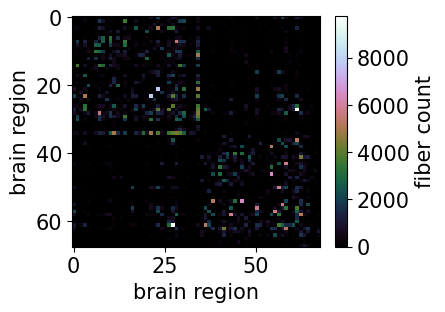

In [4]:
# check brain adjacency matrix

plt.figure(figsize=(4, 3))
plt.imshow(brain_networks.mean(0).reshape(n_rois, n_rois)*count_offset, aspect='auto', cmap='cubehelix')
plt.xlabel('brain region')
plt.ylabel('brain region')
plt.colorbar(label='fiber count')
plt.show()

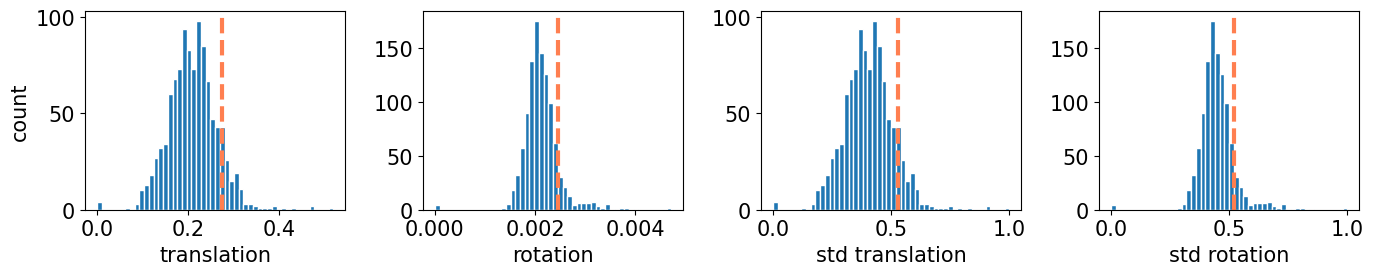

In [5]:
# check motion and rescale motion
std_trans = min_max_standardize(avg_trans)
std_rotat = min_max_standardize(avg_rotat)
motion = np.concatenate([std_trans, std_rotat], axis=-1)

fig, axes = plt.subplots(1,4,figsize=(14,3))
axes[0].hist(avg_trans, 50, edgecolor='white')
axes[0].axvline(x=np.quantile(avg_trans, .9), color='coral', ls='dashed', lw=3)
axes[0].set_xlabel('translation')
axes[0].set_ylabel('count')
axes[1].hist(avg_rotat, 50, edgecolor='white')
axes[1].axvline(x=np.quantile(avg_rotat, .9), color='coral', ls='dashed', lw=3)
axes[1].set_xlabel('rotation')
axes[2].hist(std_trans, 50, edgecolor='white')
axes[2].axvline(x=np.quantile(std_trans, .9), color='coral', ls='dashed', lw=3)
axes[2].set_xlabel('std translation')
axes[3].hist(std_rotat, 50, edgecolor='white')
axes[3].axvline(x=np.quantile(std_rotat, .9), color='coral', ls='dashed', lw=3)
axes[3].set_xlabel('std rotation')
plt.tight_layout()
plt.show()

model fitting

In [6]:
# model config

config = Namespace(n_nodes=n_rois, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.,
    alpha = 1, beta = .2, gamma = 1, add_reg = True, y_dim = 1, 
    batch_size=32, n_epochs=100, lr=1e-6, device=DEVICE)

In [7]:
# prepare torch datasets for training

ids = list(range(n_subs))
random.shuffle(ids)
train_ids = ids[:int(.9*n_subs)]
val_ids = ids[int(.9*n_subs):]
print(len(train_ids), len(val_ids))

tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(traits[:,4]).to(torch.float32) # oral reading recognition score

train_set = utils.TensorDataset(tensor_nets[train_ids], tensor_motion[train_ids], tensor_traits[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], tensor_motion[val_ids],  tensor_traits[val_ids])

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

958 107


In [8]:
# create masks for graph convolution layers

A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]
print(len(knn_masks), knn_masks[0].shape)

5 torch.Size([68, 68])


vae

In [10]:
model = VAE(config).to(config.device)
model.set_mask(knn_masks)
optimizer = optim.Adam(model.parameters(), lr=config.lr) 

In [11]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = model.reg_train(epoch, train_loader, model, optimizer, config.device, n_epoch_display=5)
    val_loss = model.reg_test(epoch, val_loader, model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 16856.560 nll: 5145.060 kl: 176.292 rmse: 19.116
epoch: 0 train loss: 15559.328 nll: 4375.246 kl: 182.654 rmse: 19.946
epoch: 5 train loss: 8702.469 nll: -1222.648 kl: 294.384 rmse: 17.571
epoch: 5 train loss: 7612.357 nll: -1813.821 kl: 329.832 rmse: 18.273
epoch: 10 train loss: 1907.167 nll: -6115.230 kl: 724.318 rmse: 15.699
epoch: 10 train loss: 955.117 nll: -6593.336 kl: 801.963 rmse: 16.228
epoch: 15 train loss: -3667.626 nll: -9900.256 kl: 1559.556 rmse: 13.609
epoch: 15 train loss: -4457.890 nll: -10285.317 kl: 1685.195 rmse: 13.982
epoch: 20 train loss: -7840.661 nll: -12671.617 kl: 2747.237 rmse: 11.570
epoch: 20 train loss: -8461.074 nll: -12969.844 kl: 2913.848 rmse: 11.815
epoch: 25 train loss: -10705.553 nll: -14542.685 kl: 4171.621 rmse: 9.687
epoch: 25 train loss: -11169.573 nll: -14765.203 kl: 4366.103 rmse: 9.829
epoch: 30 train loss: -12466.838 nll: -15681.170 kl: 5633.463 rmse: 8.073
epoch: 30 train loss: -12802.223 nll: -15847.327 kl: 5832.635 

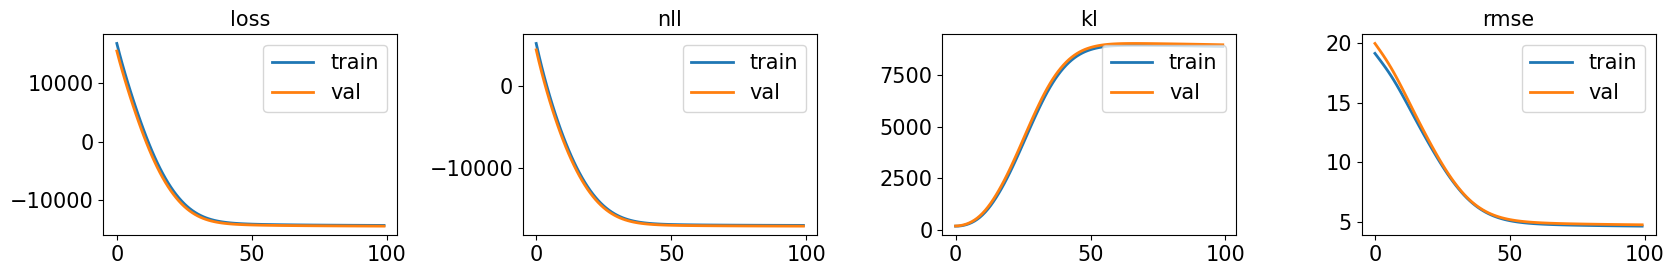

In [15]:
# diagnostics
fig, axes = plt.subplots(1, 4, figsize=(17, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('rmse')
axes[3].legend(loc=1)
plt.tight_layout()
plt.show()

In [14]:
# torch.save(model.state_dict(), './pretrained/hcp_vae_pretrained.mod')
model.load_state_dict(torch.load('./pretrained/hcp_vae_pretrained.mod'))

<All keys matched successfully>

In [16]:
z_mean, z_logvar = model.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
z_sample = model.reparameterize(z_mean, z_logvar)
vae_latents = z_sample.detach().cpu().numpy()
x_recon = model.decode(z_sample).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)

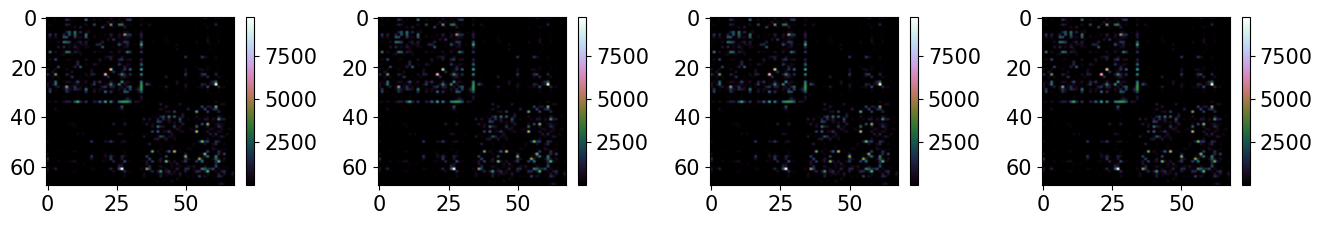

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(13.5, 2.5))
for i, x in enumerate(x_recon[np.random.choice(ids, 4, replace=False)]):
    p = axes[i].imshow(x*count_offset, aspect='auto', cmap='cubehelix')
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

In [ ]:
# to do - add viz for recon, motion correction and trait prediction, etc.



inv-vae

In [24]:
# model config

config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=2,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.,
    # alpha = 1.1, beta = 1., gamma = .1, add_reg = True, y_dim = 1,
    alpha = 1.1, beta = .2, gamma = .1, add_reg = True, y_dim = 1,
    batch_size=32, n_epochs=100, lr=2e-6, device=DEVICE)

In [25]:
inv_model = INV_VAE(config).to(config.device)
inv_model.set_mask(knn_masks)
optimizer = optim.Adam(inv_model.parameters(), lr=config.lr) 

In [26]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = inv_model.reg_train(epoch, train_loader, inv_model, optimizer, config.device, n_epoch_display=5)
    val_loss = inv_model.reg_test(epoch, val_loader, inv_model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 15784.918 nll: 4172.167 kl: 449.834 inv_loss: 4.846 rmse: 18.640
epoch: 0 test loss 13684.692 nll: 2754.012 kl: 373.109 inv_loss: 6.468 rmse: 19.586
epoch: 5 train loss: 755.529 nll: -6475.150 kl: 957.450 inv_loss: 6.242 rmse: 15.504
epoch: 5 test loss -817.960 nll: -7425.897 kl: 1141.384 inv_loss: 10.413 rmse: 16.068
epoch: 10 train loss: -9045.089 nll: -12780.427 kl: 3104.612 inv_loss: 8.445 rmse: 11.713
epoch: 10 test loss -10109.729 nll: -13422.155 kl: 3485.332 inv_loss: 13.572 rmse: 11.974
epoch: 15 train loss: -13786.798 nll: -15724.617 kl: 6102.569 inv_loss: 9.698 rmse: 8.448
epoch: 15 test loss -14384.642 nll: -16120.726 kl: 6568.407 inv_loss: 12.973 rmse: 8.580
epoch: 20 train loss: -15252.491 nll: -16601.526 kl: 8452.376 inv_loss: 10.612 rmse: 6.403
epoch: 20 test loss -15617.225 nll: -16889.830 kl: 8839.671 inv_loss: 13.331 rmse: 6.564
epoch: 25 train loss: -15574.715 nll: -16774.982 kl: 9431.992 inv_loss: 11.010 rmse: 5.547
epoch: 25 test loss -15874.77

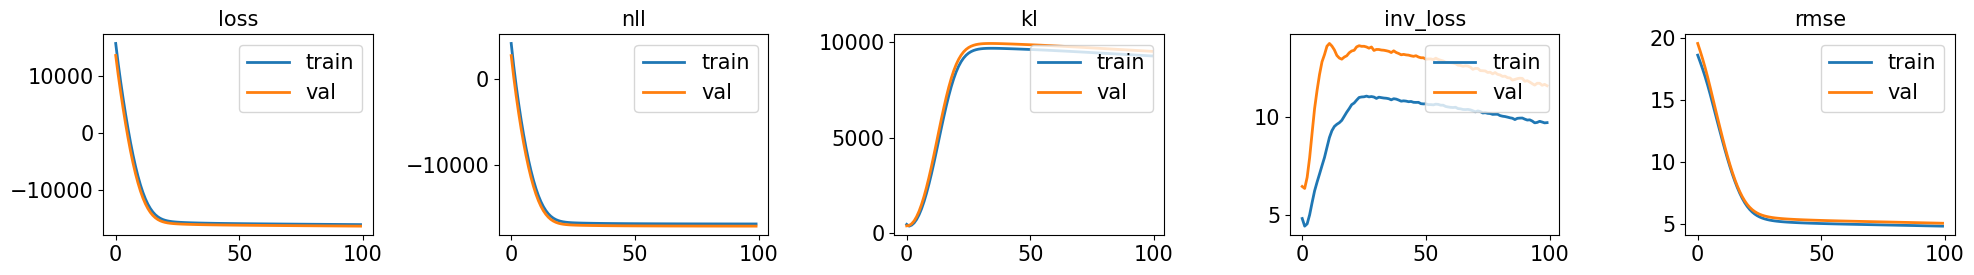

In [27]:
# diagnostics
fig, axes = plt.subplots(1, 5, figsize=(20, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('inv_loss')
axes[3].legend(loc=1)

axes[4].plot(train_losses[:,4], linewidth=2, label='train')
axes[4].plot(val_losses[:,4], linewidth=2, label='val')
axes[4].set_title('rmse')
axes[4].legend(loc=1)

plt.tight_layout()
plt.show()

In [28]:
z_mean, z_logvar = inv_model.encode(tensor_nets.to(config.device))
z_sample = inv_model.reparameterize(z_mean, z_logvar)
inv_latents = z_sample.detach().cpu().numpy()
x_recon = inv_model.decode(z_sample, 
                      tensor_motion.to(config.device) 
                      ).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)
x_denoised = inv_model.decode(z_sample, 
                      torch.zeros_like(tensor_motion).to(config.device) 
                      ).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)

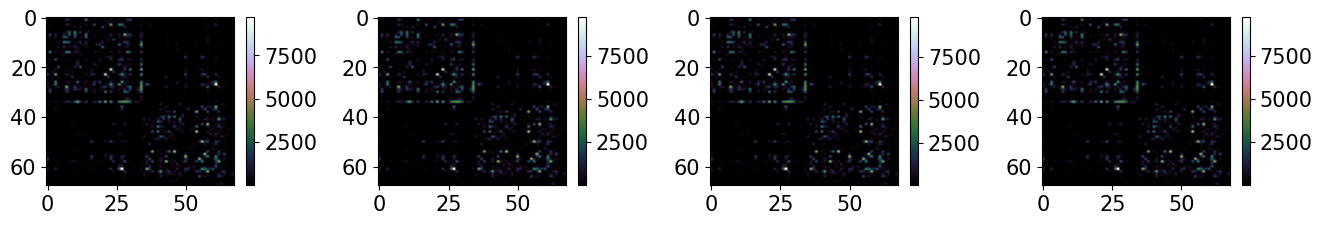

In [29]:
fig, axes = plt.subplots(1, 4, figsize=(13.5, 2.5))
for i, x in enumerate(x_recon[np.random.choice(ids, 4, replace=False)]):
    p = axes[i].imshow(x*count_offset, aspect='auto', cmap='cubehelix')
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

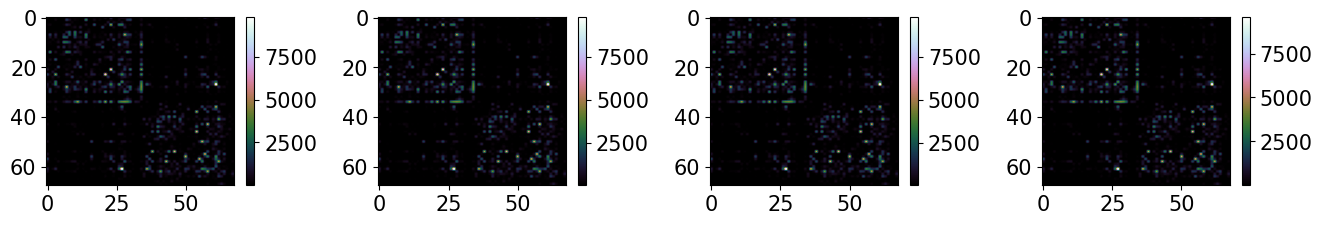

In [30]:
fig, axes = plt.subplots(1, 4, figsize=(13.5, 2.5))
for i, x in enumerate(x_denoised[np.random.choice(ids, 4, replace=False)]):
    p = axes[i].imshow(x*count_offset, aspect='auto', cmap='cubehelix')
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  